# Load the Dataset

In [595]:
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler, SMOTEN

from mord import LogisticAT

In [537]:
pd.set_option('display.max_columns', None)

In [538]:
df = pd.read_csv('../data/model_ready/full_table-2022.csv', sep=';')
df_test = pd.read_csv('../data/model_ready/full_table-2023.csv', sep=';')

In [539]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126662 entries, 0 to 126661
Data columns (total 52 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   day                                            126662 non-null  int64  
 1   month                                          126662 non-null  int64  
 2   lighting_condition                             126662 non-null  int64  
 3   location                                       126662 non-null  int64  
 4   intersection                                   126662 non-null  int64  
 5   weather_condition                              126662 non-null  int64  
 6   type_of_collision                              126662 non-null  int64  
 7   latitude                                       126662 non-null  float64
 8   longitude                                      126662 non-null  float64
 9   hour                                 

In [540]:
df

,day,month,lighting_condition,location,intersection,weather_condition,type_of_collision,latitude,longitude,hour,minute,road_category,traffic_regime,number_of_traffic_lanes,reserved_lane_present,longitudinal_profile,horizontal_alignment,pavement_condition,infrastructure,accident_situation,speed_limit,position,user_category,injury_severity,sex,pedestrian_location,pedestrian_action,age,used_belt,used_helmet,used_child_restraint,used_airbag,direction_of_travel,vehicle_category,fixed_obstacle_struck,mobile_obstacle_struck,initial_point_of_impact,main_maneuver_before_accident,motor_type,direction_of_travel_other,vehicle_category_other,fixed_obstacle_struck_other,mobile_obstacle_struck_other,initial_point_of_impact_other,main_maneuver_before_accident_other,motor_type_other,vehicle_category_involved_bicycle,vehicle_category_involved_bus_coach,vehicle_category_involved_hgv_truck,vehicle_category_involved_light_motor_vehicle,vehicle_category_involved_other,vehicle_category_involved_powered_2_3_wheeler
0,19,10,1,2,3,1,3,44.559420,4.725720,16,15,4,2,2.0,0,1,1,1,0,1,50,1,1,3,1,-1,-1,14.0,0,1,0,0,1.0,powered_2_3_wheeler,0.0,2.0,1.0,9.0,1.0,1.0,light_motor_vehicle,0.0,2.0,2.0,1.0,1.0,0,0,0,1,0,1
1,19,10,1,2,3,1,3,44.559420,4.725720,16,15,4,2,2.0,0,1,1,1,0,1,50,1,1,1,1,-1,-1,74.0,1,0,0,0,1.0,light_motor_vehicle,0.0,2.0,2.0,1.0,1.0,1.0,powered_2_3_wheeler,0.0,2.0,1.0,9.0,1.0,0,0,0,1,0,1
2,20,10,1,2,3,1,3,46.925810,6.346200,8,34,4,2,2.0,0,1,1,1,0,1,50,1,1,4,1,0,0,34.0,1,0,0,0,2.0,light_motor_vehicle,0.0,2.0,8.0,15.0,1.0,2.0,light_motor_vehicle,0.0,2.0,1.0,1.0,1.0,0,0,0,2,0,0
3,20,10,1,2,3,1,3,46.925810,6.346200,8,34,4,2,2.0,0,1,1,1,0,1,50,1,1,1,1,0,0,52.0,1,0,0,0,2.0,light_motor_vehicle,0.0,2.0,1.0,1.0,1.0,2.0,light_motor_vehicle,0.0,2.0,8.0,15.0,1.0,0,0,0,2,0,0
4,20,10,1,2,6,1,2,48.493162,-2.760439,17,15,3,-1,2.0,0,1,1,1,5,1,50,1,1,1,1,-1,-1,20.0,1,0,0,0,2.0,light_motor_vehicle,0.0,2.0,1.0,2.0,1.0,1.0,light_motor_vehicle,0.0,2.0,4.0,2.0,1.0,0,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126657,1,1,1,1,3,1,3,43.927265,1.915637,8,40,3,2,2.0,0,1,1,1,0,1,80,1,1,1,2,0,0,20.0,1,0,0,0,2.0,light_motor_vehicle,0.0,0.0,8.0,19.0,1.0,2.0,light_motor_vehicle,0.0,2.0,1.0,1.0,1.0,0,0,0,2,0,0
126658,1,1,1,1,3,1,3,43.927265,1.915637,8,40,3,2,2.0,0,1,1,1,0,1,80,8,2,3,2,0,0,18.0,1,0,0,0,2.0,light_motor_vehicle,0.0,0.0,8.0,19.0,1.0,2.0,light_motor_vehicle,0.0,2.0,1.0,1.0,1.0,0,0,0,2,0,0
126659,1,1,1,1,3,1,3,43.927265,1.915637,8,40,3,2,2.0,0,1,1,1,0,1,80,1,1,4,2,0,0,69.0,1,0,0,0,2.0,light_motor_vehicle,0.0,2.0,1.0,1.0,1.0,2.0,light_motor_vehicle,0.0,0.0,8.0,19.0,1.0,0,0,0,2,0,0
126660,1,3,1,2,1,1,2,47.594404,1.353329,16,55,3,3,4.0,0,1,1,1,0,1,70,1,1,3,1,-1,-1,30.0,0,1,0,0,1.0,powered_2_3_wheeler,0.0,2.0,1.0,1.0,1.0,1.0,light_motor_vehicle,0.0,0.0,4.0,21.0,1.0,0,0,0,1,0,1


In [541]:
for x in [df, df_test]:
    x['injury_severity'] = x['injury_severity'].map({1:1, 2:4, 3:3, 4:2})
    x[['vehicle_category', 'vehicle_category_other']] = x[['vehicle_category', 'vehicle_category_other']].fillna('no_vehicle')
    x.fillna(-1, inplace=True)
    x.drop(columns=['day', 'month', 'latitude', 'longitude', 'hour', 'minute'], inplace=True)
    x.drop(index=x.index[x['injury_severity'] == -1], inplace=True)
    x['pedestrian_action'] = pd.to_numeric(x['pedestrian_action'], errors='coerce').fillna(-1)
    x[x.select_dtypes(include='float64').columns] = x[x.select_dtypes(include='float64').columns].astype(int)
    x.dropna(inplace=True)

In [ ]:
df

In [542]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 126421 entries, 0 to 126661
Data columns (total 46 columns):
 #   Column                                         Non-Null Count   Dtype 
---  ------                                         --------------   ----- 
 0   lighting_condition                             126421 non-null  int64 
 1   location                                       126421 non-null  int64 
 2   intersection                                   126421 non-null  int64 
 3   weather_condition                              126421 non-null  int64 
 4   type_of_collision                              126421 non-null  int64 
 5   road_category                                  126421 non-null  int64 
 6   traffic_regime                                 126421 non-null  int64 
 7   number_of_traffic_lanes                        126421 non-null  int64 
 8   reserved_lane_present                          126421 non-null  int64 
 9   longitudinal_profile                           126421

In [604]:
cat_cols = [
    'lighting_condition', 'location', 'intersection', 'weather_condition', 'type_of_collision', 'road_category', 'traffic_regime', 'reserved_lane_present', 'longitudinal_profile',
    'horizontal_alignment', 'pavement_condition', 'infrastructure', 'accident_situation', 'user_category', 'sex', 'pedestrian_location', 'pedestrian_action', 'direction_of_travel', 'vehicle_category', 'fixed_obstacle_struck',
    'mobile_obstacle_struck', 'initial_point_of_impact', 'main_maneuver_before_accident', 'motor_type', 'direction_of_travel_other', 'vehicle_category_other', 'fixed_obstacle_struck_other', 'mobile_obstacle_struck_other',
    'initial_point_of_impact_other', 'main_maneuver_before_accident_other', 'motor_type_other'
]

In [543]:
X_train = df.drop(columns='injury_severity')
y_train = df['injury_severity']

In [544]:
X_test = df_test.drop(columns='injury_severity')
y_test = df_test['injury_severity']

In [ ]:
#cat_cols = ['vehicle_category','vehicle_category_other']
num_cols = X_train.select_dtypes(include='number').columns


transformer = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
    ('num', MinMaxScaler(), num_cols),
], remainder='passthrough')

pipeline = ImbPipeline(steps=[
    ('pre', transformer),
    ('os', SMOTE(random_state=42, k_neighbors=200)),  # try RandomUnderSampler() or SMOTE for numeric-only
    ('clf', KNeighborsClassifier(n_neighbors=200, n_jobs=-1)),
])

pipeline.fit(X_train, y_train)
y_predict = pipeline.predict(X_test)

KeyboardInterrupt: 

In [546]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           1       0.82      0.71      0.76     53399
           2       0.64      0.41      0.50     49603
           3       0.30      0.44      0.36     19271
           4       0.10      0.60      0.17      3398

    accuracy                           0.55    125671
   macro avg       0.47      0.54      0.45    125671
weighted avg       0.65      0.55      0.58    125671



In [613]:
#cat_cols = ['vehicle_category','vehicle_category_other']
num_cols = X_train.select_dtypes(include='number').columns

transformer = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_cols)
], remainder='passthrough')

pipeline = ImbPipeline(steps=[
    ('pre', transformer),
    ('os', SMOTEN(k_neighbors=50, random_state=42, sampling_strategy='minority')),  # try RandomUnderSampler() or SMOTE for numeric-only
    ('clf', LogisticRegression(max_iter=2000, n_jobs=-1, class_weight={1:1, 2:8, 3:27, 4:64}, penalty='l2')),
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.97      0.48      0.65     53399
           2       0.56      0.62      0.59     49603
           3       0.33      0.58      0.42     19271
           4       0.13      0.43      0.20      3398

    accuracy                           0.55    125671
   macro avg       0.50      0.53      0.46    125671
weighted avg       0.69      0.55      0.58    125671



In [598]:
cat_cols = [c for c in ['vehicle_category','vehicle_category_other'] if c in X_train.columns]
num_cols = X_train.select_dtypes(include='float64').astype(int)

pre = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
], remainder='passthrough')

pipeline = ImbPipeline([
    ('pre', pre),
    ('sd', SMOTEN(sampling_strategy='minority', random_state=42)),
    ('ord', LogisticAT())  # ordinal logistic (proportional odds)
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

In [599]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.71      0.60      0.65     53399
           2       0.48      0.50      0.49     49603
           3       0.29      0.22      0.25     19271
           4       0.11      0.43      0.17      3398

    accuracy                           0.50    125671
   macro avg       0.40      0.44      0.39    125671
weighted avg       0.54      0.50      0.52    125671



In [ ]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

pre = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols),
], remainder='passthrough')


Xtr = pre.fit_transform(X_train)
Xte = pre.transform(X_test)

import numpy as np


# 2. Build ordered logit model
#    `distr="logit"` gives proportional-odds logistic regression.
model = OrderedModel(
    y_train.astype(int),
    Xtr,   # add intercept column
    distr="logit"
)

# 3. Fit (we'll use method="bfgs" which is common for this model)
res = model.fit(method="bfgs")
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.856958
         Iterations: 272
         Function evaluations: 276
         Gradient evaluations: 276
                             OrderedModel Results                             
Dep. Variable:        injury_severity   Log-Likelihood:            -1.0834e+05
Model:                   OrderedModel   AIC:                         2.168e+05
Method:            Maximum Likelihood   BIC:                         2.174e+05
Date:                Wed, 29 Oct 2025                                         
Time:                        20:40:24                                         
No. Observations:              126421                                         
Df Residuals:                  126363                                         
Df Model:                          55                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------

In [ ]:
# --- predict class probabilities for first 5 rows ---
probs = res.model.predict(res.params, exog=Xte, which='prob')
print("Class probability rows:\n", probs)

classes = np.sort(y_train.unique())

y_pred = classes[probs.argmax(axis=1)]

Class probability rows:
 [[0.21108422 0.58744587 0.1779499  0.02352001]
 [0.66143145 0.3051681  0.03011246 0.00328799]
 [0.11299299 0.54063113 0.29822092 0.04815496]
 ...
 [0.83543303 0.15144382 0.01185526 0.00126788]
 [0.87017117 0.11985738 0.00901083 0.00096061]
 [0.04760788 0.37784118 0.46034961 0.11420134]]


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.75      0.75      0.75     53399
           2       0.54      0.69      0.61     49603
           3       0.44      0.21      0.29     19271
           4       0.11      0.01      0.01      3398

    accuracy                           0.62    125671
   macro avg       0.46      0.41      0.41    125671
weighted avg       0.60      0.62      0.60    125671



In [ ]:
# pip install mord
import mord
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

cat_cols = [c for c in ['vehicle_category','vehicle_category_other'] if c in X_train.columns]
num_cols = X_train.select_dtypes(include='number').columns

pre = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
    ('num', MinMaxScaler(), list(num_cols)),
], remainder='passthrough')

pipeline = Pipeline([
    ('pre', pre),
    ('ord',mord.LAD())  # ordinal logistic (proportional odds)
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

c:\Users\David\Desktop\PythonKurs\Data Mining I\Project\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.78      0.70      0.74     53399
         2.0       0.53      0.77      0.63     49603
         3.0       0.45      0.10      0.17     19271
         4.0       0.33      0.00      0.00      3398

    accuracy                           0.62    125671
   macro avg       0.42      0.32      0.31    125671
weighted avg       0.62      0.62      0.59    125671



c:\Users\David\Desktop\PythonKurs\Data Mining I\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\David\Desktop\PythonKurs\Data Mining I\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\David\Desktop\PythonKurs\Data Mining I\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

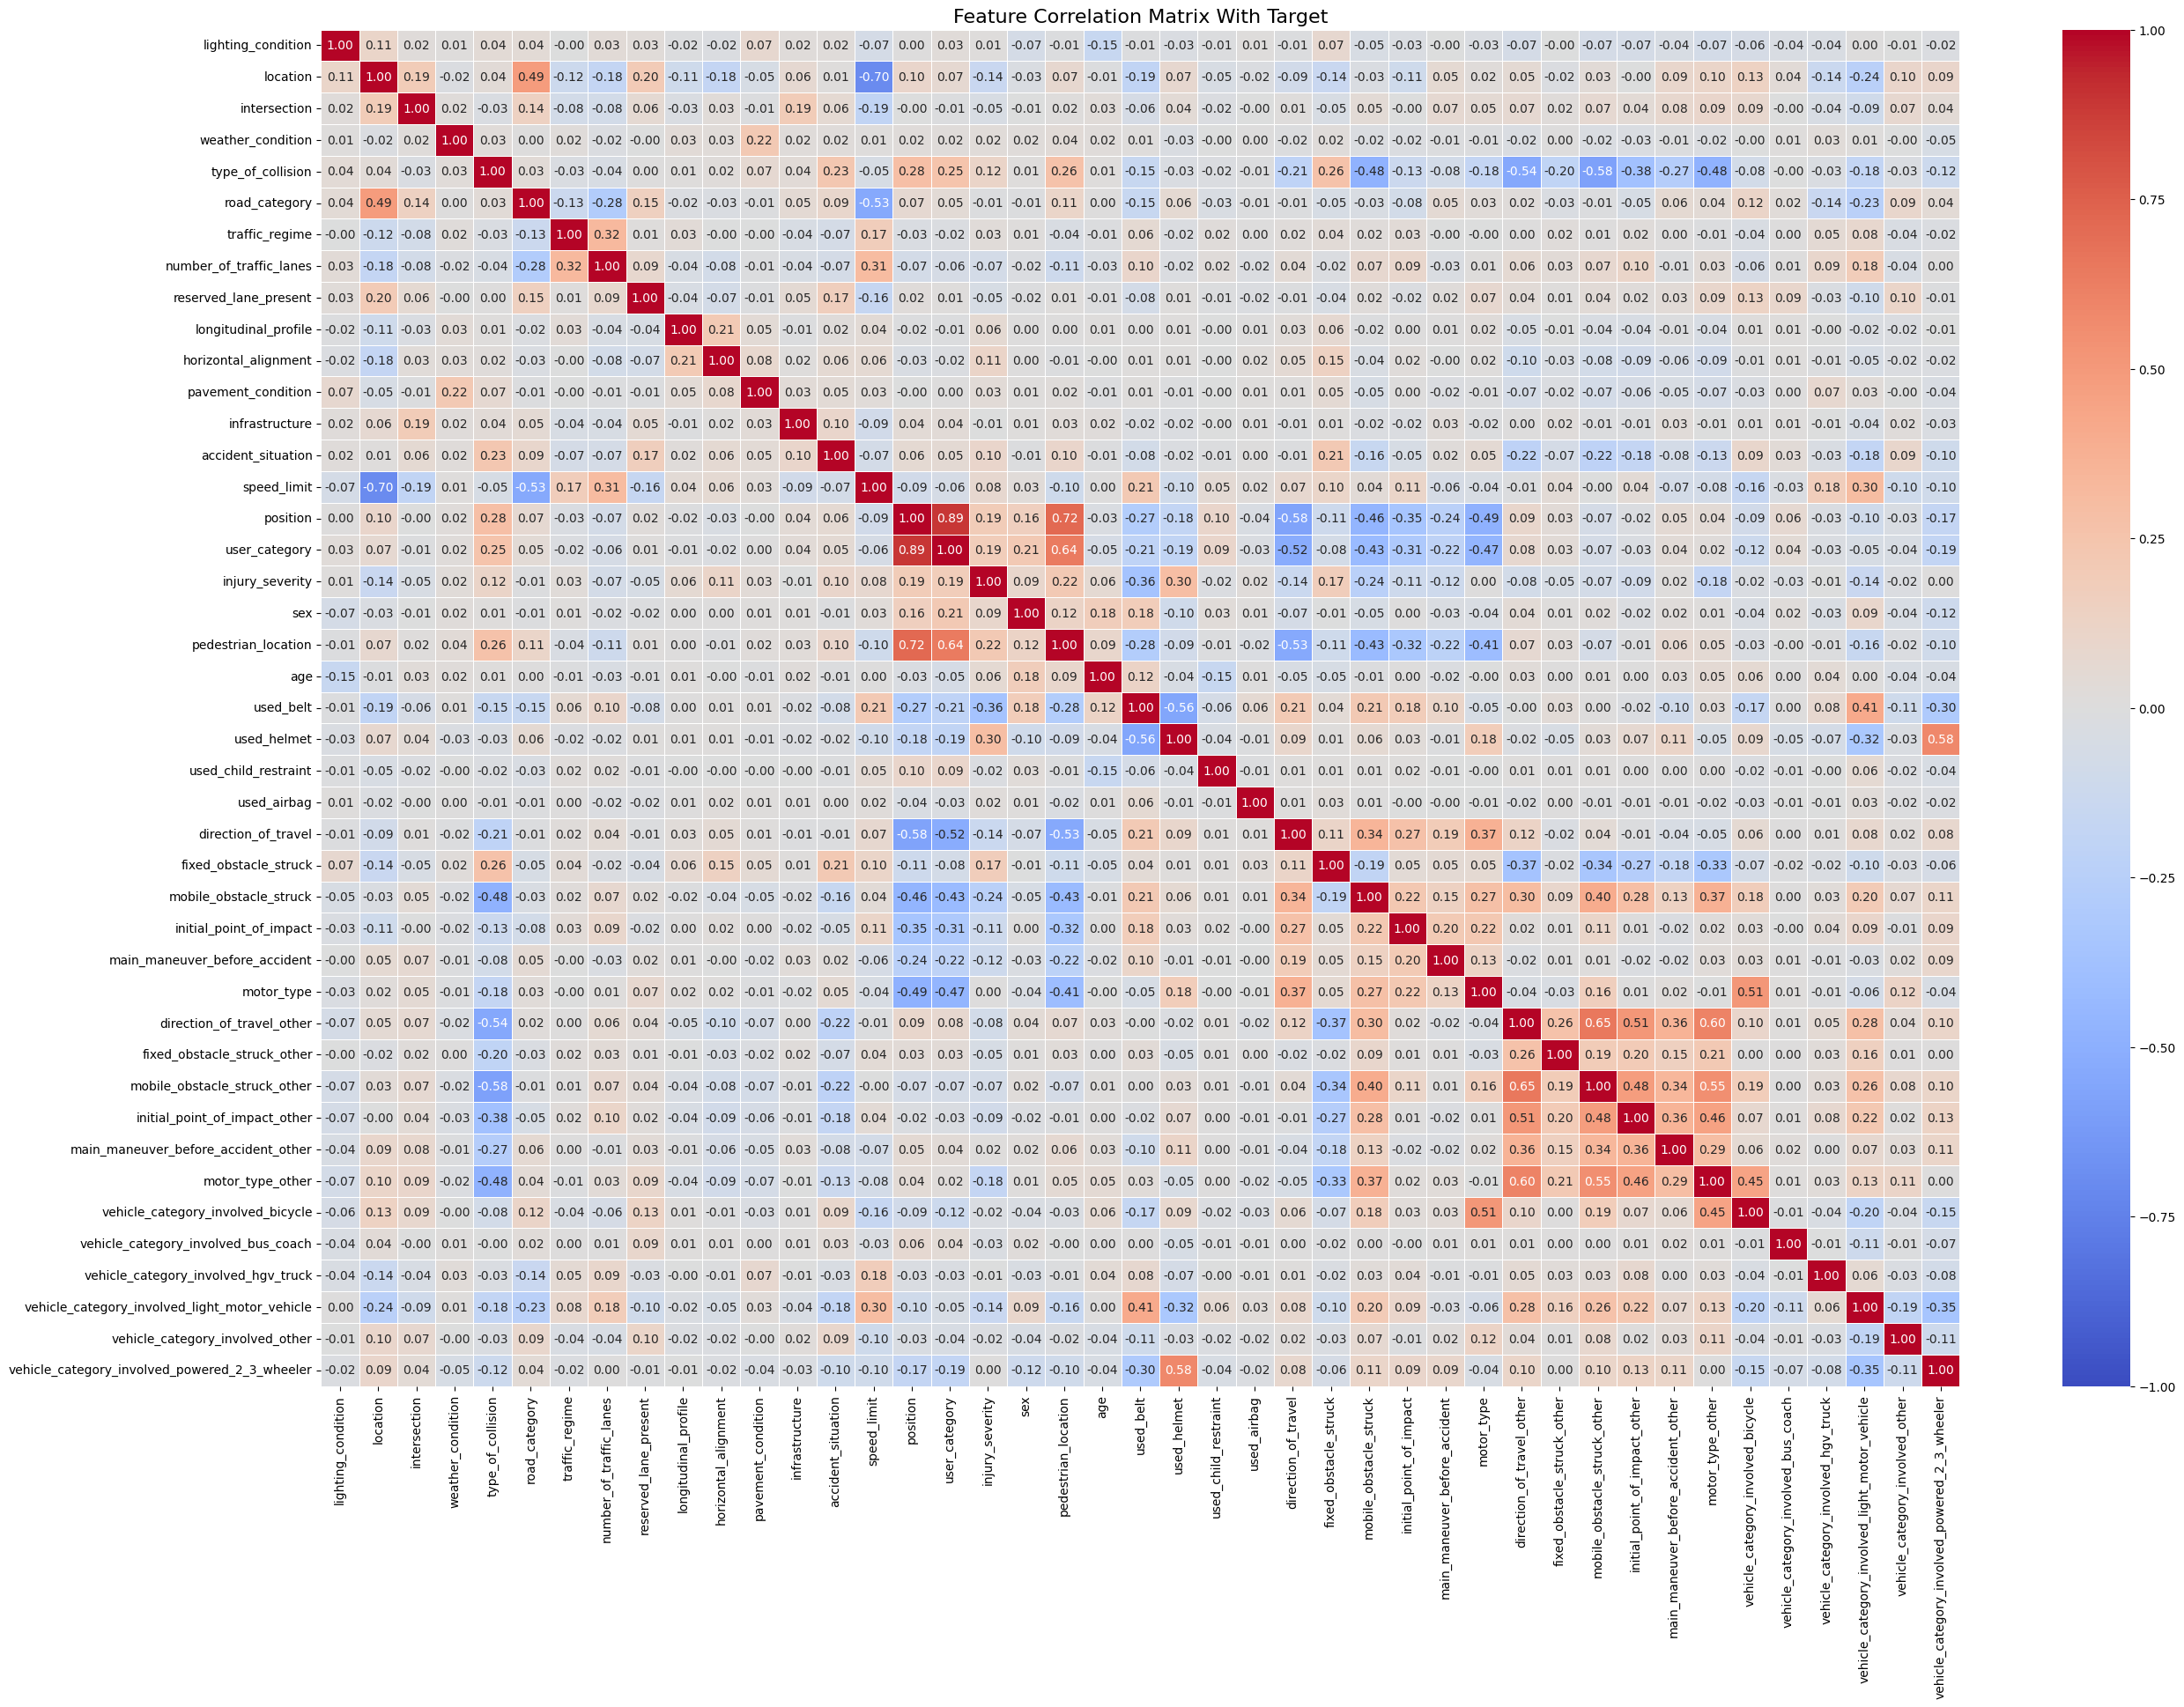

In [ ]:
# Compute correlation matrix
corr_matrix = df.select_dtypes(include=['number']).corr()

# Plot heatmap
plt.figure(figsize=(30, 20))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix With Target", fontsize=16)
plt.show()

In [ ]:
from catboost import CatBoostRegressor, Pool
import numpy as np

cat_features_idx = range(len(X_train.columns))  # indices of categorical columns in X





train_pool = Pool(X_train, y_train, cat_features=cat_features_idx)
test_pool  = Pool(X_test,  y_test,  cat_features=cat_features_idx)

model = CatBoostRegressor(
    depth=10,
    learning_rate=0.05,
    num_trees=200,
    loss_function='RMSE',  # or RMSE
    task_type='GPU',
    devices='0',
)

model.fit(train_pool, verbose=False)

y_pred_cont = model.predict(test_pool)
y_pred = np.clip(np.rint(y_pred_cont), 1, 4).astype(int)

In [557]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.88      0.71      0.78     53399
           2       0.59      0.83      0.69     49603
           3       0.52      0.33      0.40     19271
           4       0.63      0.01      0.01      3398

    accuracy                           0.68    125671
   macro avg       0.65      0.47      0.47    125671
weighted avg       0.70      0.68      0.67    125671



In [562]:
cat_cols = ['vehicle_category','vehicle_category_other']
num_cols = X_train.select_dtypes(include='number').columns


X_res, y_res = RandomOverSampler(sampling_strategy='minority').fit_resample(X_train, y_train)

cat_features_idx = range(len(X_train.columns))  # indices of categorical columns in X

train_pool = Pool(X_res, y_res, cat_features=range(len(X_train.columns)))
test_pool  = Pool(X_test, y_test, cat_features=range(len(X_train.columns)))

model = CatBoostRegressor(
    depth=10,
    learning_rate=0.05,
    iterations=800,
    loss_function='MAPE',  # or RMSE
    task_type='GPU',
    devices='0'
)

model.fit(train_pool, verbose=False)
y_pred_cont = model.predict(test_pool)
y_pred = np.clip(np.rint(y_pred_cont), 1, 4).astype(int)

In [563]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       0.73      0.87      0.79     53399
           2       0.63      0.60      0.61     49603
           3       0.48      0.33      0.39     19271
           4       0.26      0.13      0.17      3398

    accuracy                           0.66    125671
   macro avg       0.53      0.48      0.49    125671
weighted avg       0.64      0.66      0.64    125671



In [591]:
from catboost import CatBoostClassifier, Pool
import numpy as np

cat_features_idx = range(len(X_train.columns))  # indices of categorical columns in X

train_pool = Pool(X_train, y_train, cat_features=cat_features_idx)
test_pool  = Pool(X_test,  y_test,  cat_features=cat_features_idx)

model = CatBoostClassifier(
    depth=6,
    learning_rate=0.005,
    iterations=1600,
    loss_function='MultiClass',  # or RMSE
    eval_metric='TotalF1',
    task_type='GPU',
    devices='0',
    auto_class_weights='Balanced'
)
model.fit(train_pool, verbose=False)

y_pred = model.predict(test_pool)

In [590]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.97      0.47      0.63     53399
           2       0.55      0.61      0.58     49603
           3       0.34      0.73      0.46     19271
           4       0.28      0.23      0.26      3398

    accuracy                           0.56    125671
   macro avg       0.53      0.51      0.48    125671
weighted avg       0.69      0.56      0.57    125671

